# Convolutions

<img src="https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif" width="750" align="center">
The 2D Image convolution is a fairly simple operation that leads to powerful and somewhat surprising results! In this notebook, we'll look at performing convolutions with a hand-crafted kernel and then look at how we can learn the parameters of a kernel to perform some task!

Have a look at this interactive convolution visualiser
[Convolution Visualizer](https://ezyang.github.io/convolution-visualizer/index.html) <br>
[Youtube: But what is a convolution? by 3Blue1Brown](https://youtu.be/KuXjwB4LzSA?si=G3Gb-GB5XAvwuw44) <br>
[Youtube:  Convolutions in image processing | Week 1 | MIT 18.S191 Fall 2020 | Grant Sanderson ](https://www.youtube.com/live/8rrHTtUzyZA?si=poQ-lPjJa6YeoJLu)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import math
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

Let's load a test image to experiment with using the Python Imaging Library (PIL).<br>
Note: PIL images are thenselves objects and the image can be displayed just by printing them

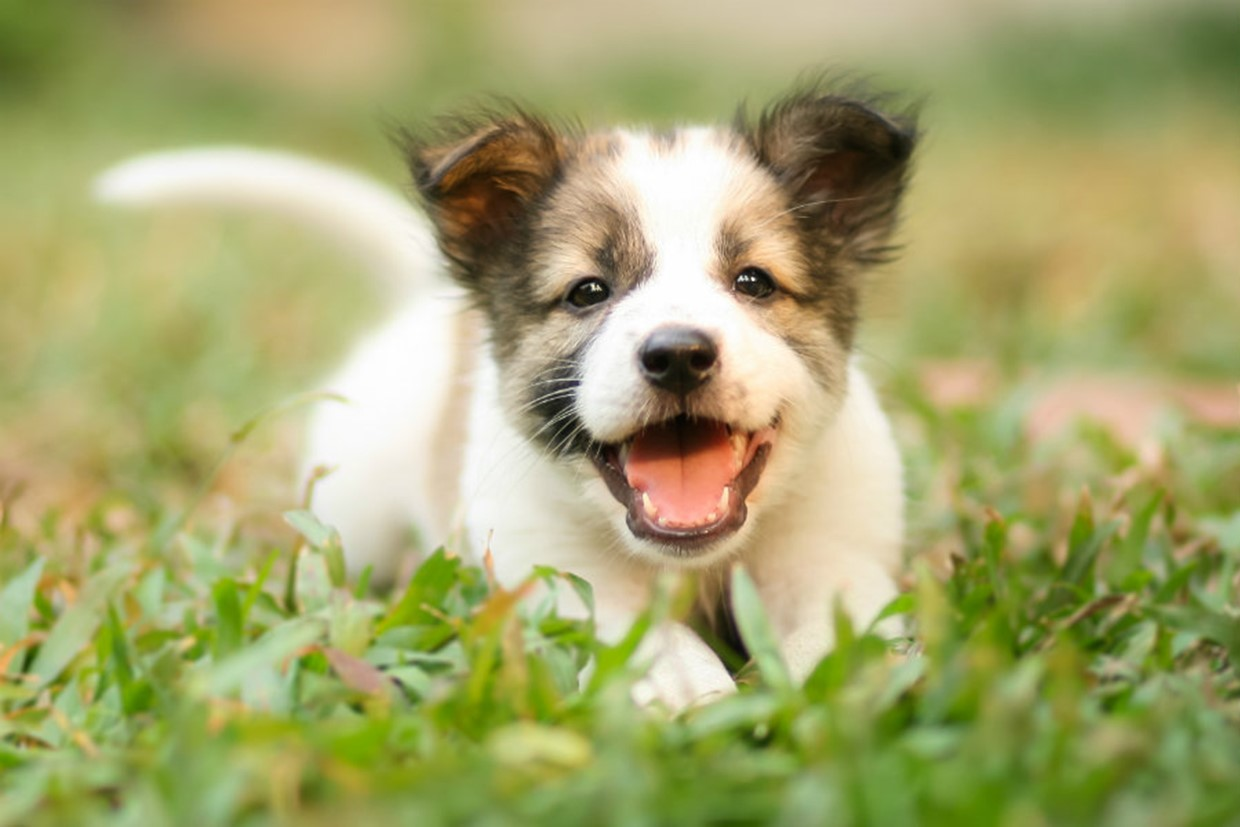

In [2]:
test_img1 = Image.open("../data/puppy.jpg").convert('RGB')
test_img1

In [3]:
# Let's create a Pytorch "transform" using the torchvision library 
# This particular transform simply takes a PIL image and converts it to a tensor
transform = T.ToTensor()
resize = T.Resize(512)
test_img1 = transform(resize(test_img1))
print("Image Shape: ", test_img1.shape)
# NOTE: Many torchvision functions only work on PIL images

Image Shape:  torch.Size([3, 512, 767])


<h2>Hand Crafted Convolution Kernels</h2>

<h3>Sobel Edge Detector</h3>
The <a href="https://en.wikipedia.org/wiki/Sobel_operator">Sobel Edge detector</a> is a famous and simple convolutional kernel filter that will "extract" the edges of an image and was/is extensively used as a part of many algorithms. Here we will create a Sobel Filter and use it on our test image.<br> By looking at the filter values can you tell how it works?<br><br>
Convolution with a Sobel Kernel (left) and the features extracted by a Sobel edge detector (right)<be>

<img src="https://miro.medium.com/max/1356/1*-OM6jQTMNACDX2vAh_lvMQ.png" width="480" align="left">
<img src="https://upload.wikimedia.org/wikipedia/commons/1/17/Bikesgraysobel.jpg" width="480" align="right">


In [4]:
# First, we must create a filter that will extract edges in the X direction
gx = torch.FloatTensor([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]).unsqueeze(0)
gx = torch.repeat_interleave(gx, 3, 0).unsqueeze(0)
print("Kernel Shape: ", gx.shape)
print(gx)

Kernel Shape:  torch.Size([1, 3, 3, 3])
tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])


In [5]:
# Now we must create a filter that will extract edges in the Y direction
gy = torch.FloatTensor([[1, 2, 1],[0, 0, 0],[-1, -2, -1]]).unsqueeze(0)
gy = torch.repeat_interleave(gy, 3, 0).unsqueeze(0)
print("Kernel Shape: ", gy.shape)
print(gy)

Kernel Shape:  torch.Size([1, 3, 3, 3])
tensor([[[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]],

         [[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]],

         [[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]]])


<h3>Convolutions in Pytorch </h3>

For the function Conv2d (which performs the convolution operation), the convolutional kernel must be of the shape  <br>
<b>[out channels, in channels, kernel height, kernel width]</b> <br>
The input image must have the shape <br>
<b>[minibatch size, in channels, image height, image width]</b> <br>

Feature Map Shape:  torch.Size([1, 1, 510, 765])


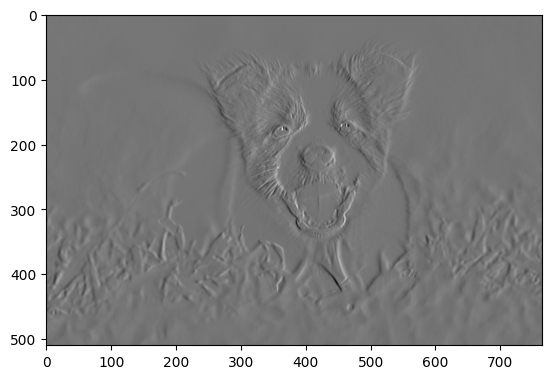

In [6]:
# Convolve the image with the X direction kernel
conv_out1 = F.conv2d(test_img1.unsqueeze(0), gx, bias=None, stride=1)
print("Feature Map Shape: ", conv_out1.shape)

_ = plt.imshow(torch.squeeze(conv_out1), cmap='gray')

Feature Map Shape:  torch.Size([1, 1, 510, 765])


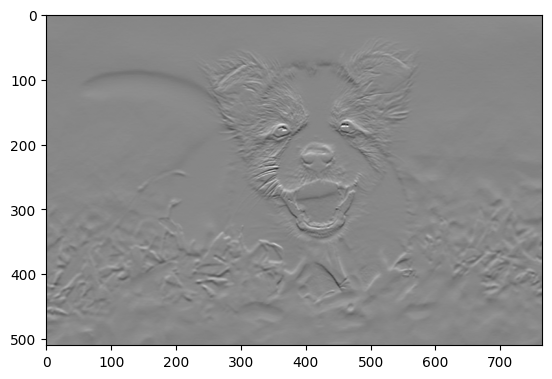

In [7]:
# Convolve the image with the Y direction kernel
conv_out2 = F.conv2d(test_img1.unsqueeze(0), gy, bias=None, stride=1)
print("Feature Map Shape: ", conv_out2.shape)

_ = plt.imshow(torch.squeeze(conv_out2), cmap='gray')

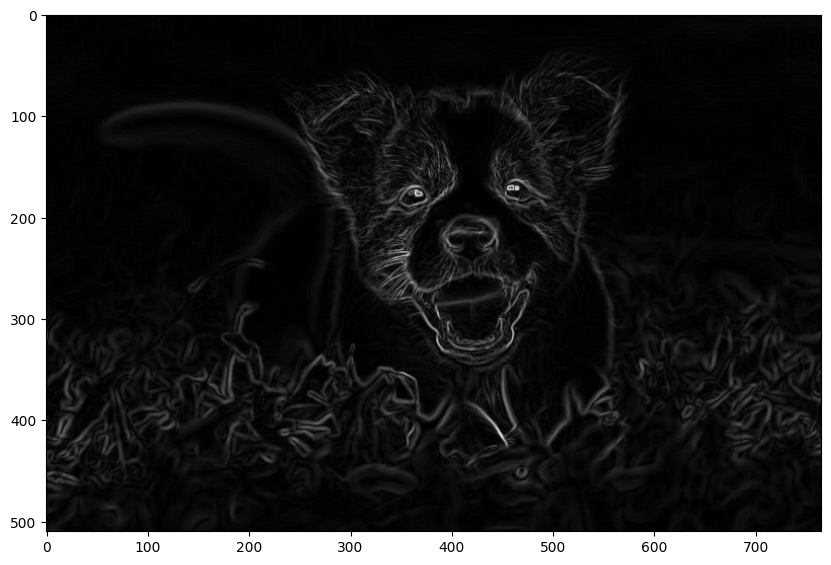

In [8]:
# Combine the two resulting images together by finding the magnitude
conv_out = (conv_out1.pow(2) + conv_out2.pow(2)).sqrt()
plt.figure(figsize = (10,10))
_ = plt.imshow(conv_out.squeeze(), cmap='gray')

<h3>Convolutional layers </h3>
Instead of doing each convolution separately, we can concatenate the kernels and perform the convolution with both kernels in one step! The ouput will have the 2D feature maps from each kernel concatenated along the channel dimension!

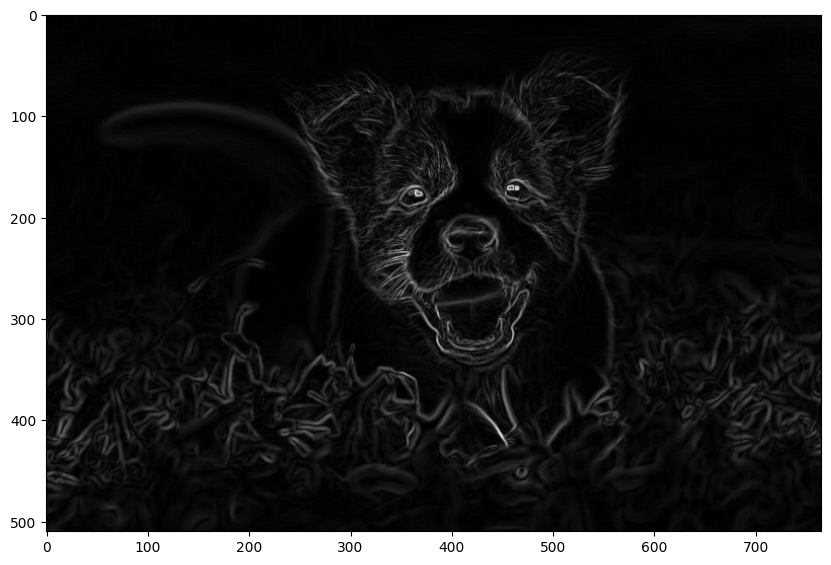

In [9]:
# Concatenate both kernels 
g_xy = torch.cat((gx, gy), 0)

# We can perform the convolutions of both kernels in the same step
conv_out3 = F.conv2d(test_img1.unsqueeze(0), g_xy, bias=None, stride=1)

# We can now easily find the magnitude
conv_out_mag = conv_out3.pow(2).sum(1).sqrt()

# We should get the same output as before!
plt.figure(figsize = (10,10))
_ = plt.imshow(conv_out_mag.squeeze(), cmap='gray')

Nope! They still look the same!

<h2> Train a Convolution Kernel! </h2>
So how do you look for something when you don't know what you are looking for? Often in computer vision we know WHAT we want, but we aren't sure how to get it! For example if you want to create an algorithm to classify cats, you might start by creating a list of all the uniquely cat-like things about an image of a cat, but then how do you go about extracting them from an image?? What if there's something you forgot? <br>
So in comes machine learning, we specify an objective (a cost function or a loss) for some learning model with the hope that by minimizing that loss our model will do what we want! (as you may have learnt by now there's a LOT more to it then that)<br>.

<img src="https://qph.fs.quoracdn.net/main-qimg-b662a8fc3be57f76c708c171fcf29960" width="480" align="center">

Did you know that Convolutions are implemented as a <a href="https://www.baeldung.com/cs/convolution-matrix-multiplication">Matrix Multiplication?</a> By doing so they are far easier to implement and can easily utilise harware accelerators to speed them up!


In [10]:
# https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html
# torch.nn.Conv2d

# Let's create a learnable 2D convolutional layer
# in_channels  - the number of input channels
# out_channels - the number of output channels, also the number of kernels in a layer
# kernel_size  - the height and width of our kernel - can be specified with a tuple for non-square kernels
# stride       - the number of pixels the kernel will "step"
# bias         - same as a linear layer, one bias term per output channel

conv_kernel = nn.Conv2d(
    in_channels = 3,
    out_channels = 1,
    kernel_size = 3,
    stride = 1,
    padding = 1,
    bias = False
)

# Define an optimizer
optimizer = optim.SGD(conv_kernel.parameters(), lr = 1e-2)

In [11]:
# Let's look at the kernel's shape
conv_kernel.weight.shape

torch.Size([1, 3, 3, 3])

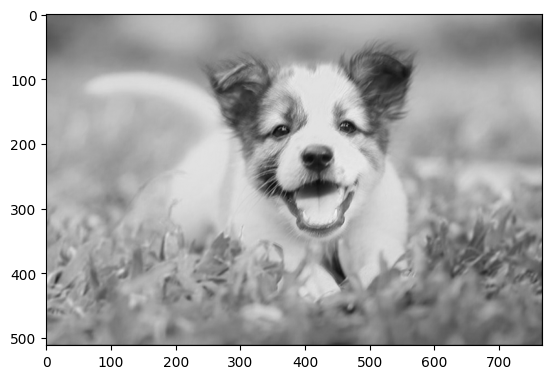

In [12]:
# We'll pass both images through the randomly initialised convolutional layers
with torch.no_grad():
    imgs_out = conv_kernel(test_img1.unsqueeze(0))

_ = plt.imshow(imgs_out[0, 0], cmap='gray')

#### Create a target for our Convolution output

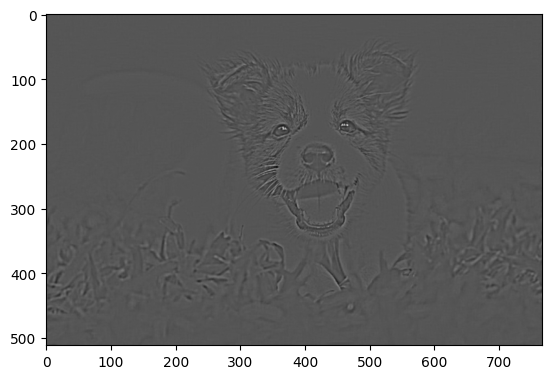

In [13]:
blur = T.GaussianBlur(7, 4)
# Blur the image and subtract this from the original
# Blurring will leave only the high-frequency components in the image
# By subtracting them from the original, we should get only the high frequency components
target = test_img1.unsqueeze(0) - blur(test_img1.unsqueeze(0))
_ = plt.imshow(torch.squeeze(target[0, 0]), cmap='gray')

<b>Training our kernel!</b><br>
Have you come up with a loss function to use yet? Perform GD with it and see what you get!

In [14]:
logger = []

for _ in trange(2000):
    imgs_out = conv_kernel(test_img1.unsqueeze(0))

    loss = (target - imgs_out).pow(2).mean()
    logger.append(loss.item())
    conv_kernel.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

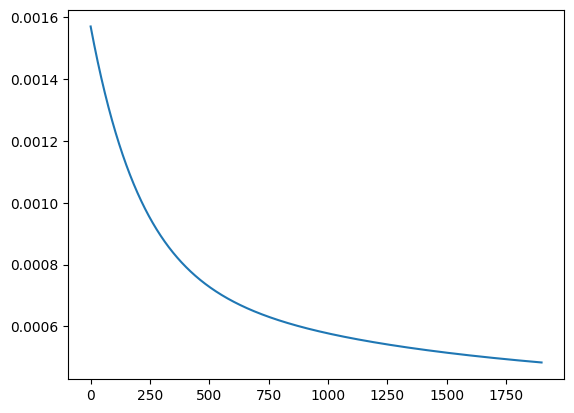

In [15]:
plt.plot(logger[100:])

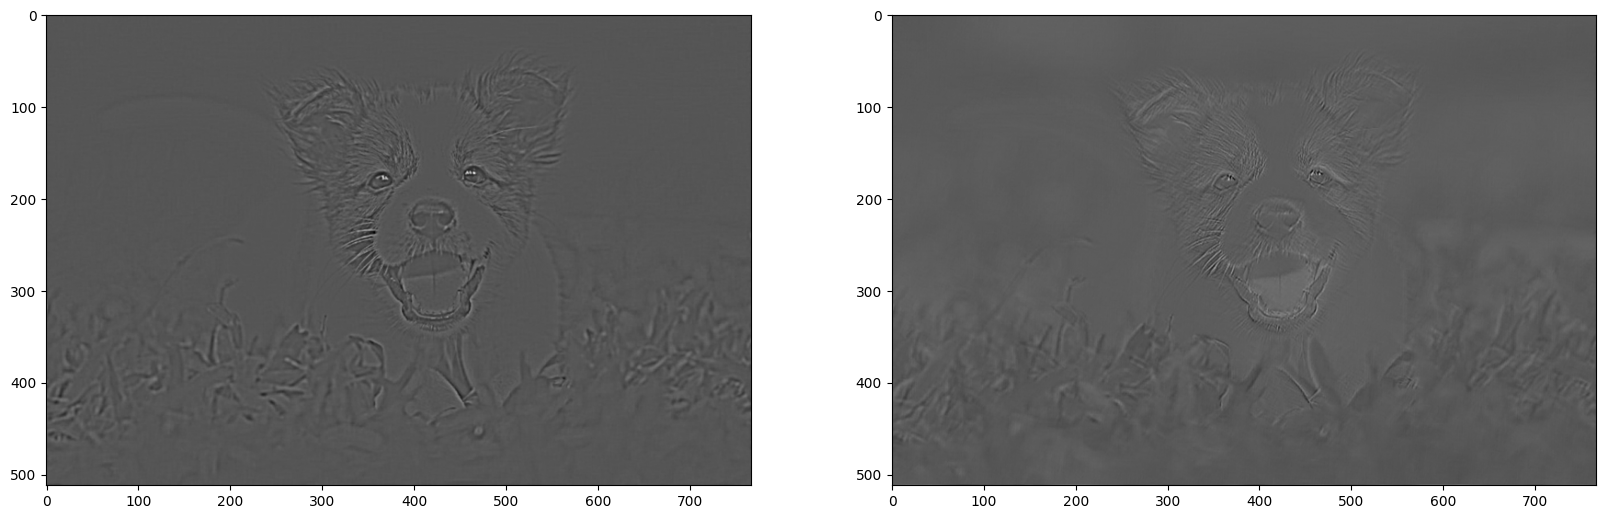

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize = (20,10))
ax1.imshow(torch.squeeze(target[0, 0]), cmap='gray')
ax2.imshow(torch.squeeze(imgs_out[0, 0].detach()), cmap='gray')

In [ ]:
plt.imshow(conv_kernel.weight.data[0].mean(0).numpy())